In [11]:
import numpy as np

# This script loads ground truth masks and prediction scores, 
# reshapes the arrays as needed, and splits data into calibration and validation sets.

# File paths for ground truth masks and prediction scores
gt_masks_path = './gt_masks.npy'
scores_path = './scores.npy'

# Load the saved numpy arrays
gt_masks = np.load(gt_masks_path)  # Load ground truth data
scores = np.load(scores_path)      # Load prediction score data

# Reshape gt_masks and scores, moving the last dimension to the third dimension
gt_masks = np.transpose(gt_masks, (1, 2, 0))
scores = np.transpose(scores, (1, 2, 0))
print("Successfully loaded gt_masks and scores files.")
print(f"Shape of gt_masks: {gt_masks.shape}")
print(f"Shape of scores: {scores.shape}")

# Split data into calibration and validation sets
# The first 15 samples are selected for the calibration set, and the remaining samples form the validation set
cal_idx = np.arange(0, 15)  # Indices for the calibration set
print(cal_idx)
val_idx = np.setdiff1d(np.arange(1, scores.shape[2]), cal_idx)  # Indices for validation set, excluding calibration set
print(val_idx)

# Extract scores and ground truth masks for calibration and validation sets
cal_scores = scores[:, :, cal_idx]  # Calibration set scores
val_scores = scores[:, :, val_idx]  # Validation set scores
cal_gt_masks = gt_masks[:, :, cal_idx]  # Calibration set ground truth masks
val_gt_masks = gt_masks[:, :, val_idx]  # Validation set ground truth masks

Successfully loaded gt_masks and scores files.
Shape of gt_masks: (584, 565, 20)
Shape of scores: (584, 565, 20)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19]


In [12]:
''' Evaluation Metric Tools'''
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
from PIL import Image
from skimage.morphology import skeletonize, skeletonize_3d
import cc3d

def interpolate(arr):
    """Normalize the array by dividing by its maximum value."""
    return arr / np.max(arr)

def dice_score(image1, image2):
    """Calculate the Dice score between two binary images."""
    # Flatten the images to 1D arrays
    image1_flat = image1.flatten()
    image2_flat = image2.flatten()

    # Calculate intersection and sum of white pixels in each image
    intersection = np.sum(image1_flat * image2_flat)
    sum_values = np.sum(image1_flat) + np.sum(image2_flat)

    # Compute the Dice score
    dice = 2.0 * intersection / sum_values
    return dice

def cl_score(v, s):
    """Compute the skeleton volume overlap.

    Args:
        v (bool): Input image.
        s (bool): Skeletonized image.

    Returns:
        float: Computed skeleton volume intersection.
    """
    return np.sum(v * s) / np.sum(s)

def clDice(v_p, v_l):
    """Compute the clDice metric.

    Args:
        v_p (bool): Predicted image.
        v_l (bool): Ground truth image.

    Returns:
        float: clDice metric value.
    """
    if len(v_p.shape) == 2:
        tprec = cl_score(v_p, skeletonize(v_l))
        tsens = cl_score(v_l, skeletonize(v_p))
    elif len(v_p.shape) == 3:
        tprec = cl_score(v_p, skeletonize_3d(v_l))
        tsens = cl_score(v_l, skeletonize_3d(v_p))
    return 2 * tprec * tsens / (tprec + tsens)

def conn_comp(arr):
    """Return the number of connected components in the input array, representing the 0-dimensional Betti number."""
    labels_out, numcomp = cc3d.connected_components(arr, connectivity=8, return_N=True)  # 26-connected
    return numcomp

def get_betti_error(arr1, arr2, patchsize=[64, 64], stepsize=[64, 64]):
    """Compute the Betti error between two images by calculating the difference in connected components.

    Args:
        arr1 (array): First binary image.
        arr2 (array): Second binary image.
        patchsize (list): Size of patches to analyze.
        stepsize (list): Step size for moving patch.

    Returns:
        float: The average Betti error across all patches.
    """
    arrsize = arr1.shape
    all_betti = []
    
    for x in range(0, arrsize[0], stepsize[0]):
        for y in range(0, arrsize[1], stepsize[1]):
            newidx = [x + patchsize[0], y + patchsize[1]]
            if check_bounds([x, y], arrsize) and check_bounds(newidx, arrsize):
                minivol1 = arr1[x:newidx[0], y:newidx[1]]
                minians1 = conn_comp(minivol1)

                minivol2 = arr2[x:newidx[0], y:newidx[1]]
                minians2 = conn_comp(minivol2)

                all_betti.append(np.abs(minians1 - minians2))

    avg_betti = np.asarray(all_betti).mean()
    return avg_betti

def check_bounds(idx, volsize):
    """Verify if the index is within the volume size bounds."""
    if idx[0] < 0 or idx[0] > volsize[0]:
        return False
    if idx[1] < 0 or idx[1] > volsize[1]:
        return False
    return True

def accuracy_score(image1, image2):
    """Calculate pixel-wise accuracy between two images."""
    correct = np.sum(image1 == image2)
    total = image1.size  # Total number of pixels
    accuracy = correct / total
    return accuracy

Calculated lamhat threshold: 0.9544888436794456
Acc: 0.9568674990907989; Dice: 0.6932494180532804; clDice: 0.7117274800856761; 0-dim Betti: 1.7083333333333333
Acc: 0.9545126682022064; Dice: 0.6411476389719067; clDice: 0.6353278404632553; 0-dim Betti: 1.7083333333333333
Acc: 0.9655746151048612; Dice: 0.7365173621581499; clDice: 0.7347770666299921; 0-dim Betti: 1.6666666666666667
Acc: 0.9689053218571948; Dice: 0.7768303823900465; clDice: 0.784852141138878; 0-dim Betti: 1.7638888888888888
Acc: 0.9679142926415323; Dice: 0.7385215737607745; clDice: 0.7471712546830148; 0-dim Betti: 1.3333333333333333
accuracy: 0.9627548793793188
dice: 0.7172532750668317
cldice: 0.7227711566001632
0betti: 1.636111111111111
(584, 565, 5)
The empirical FNR is: 0.4205915927886963 and the threshold value is: 0.9544888436794456


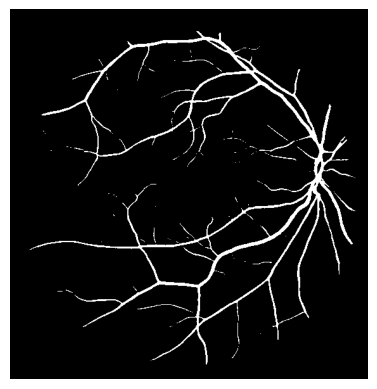

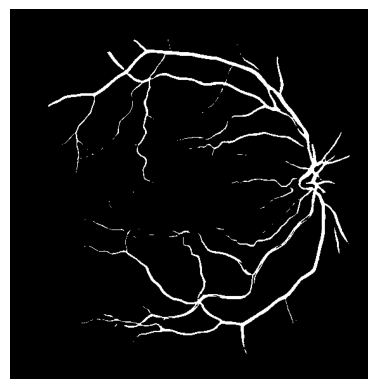

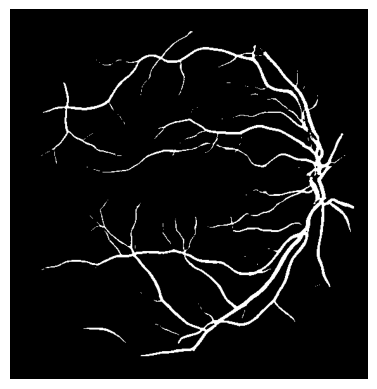

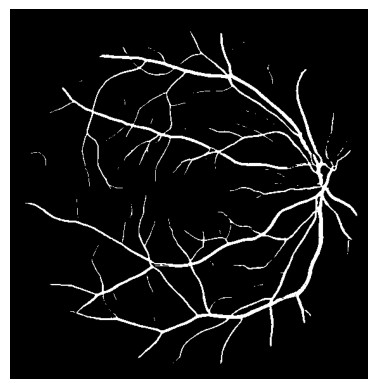

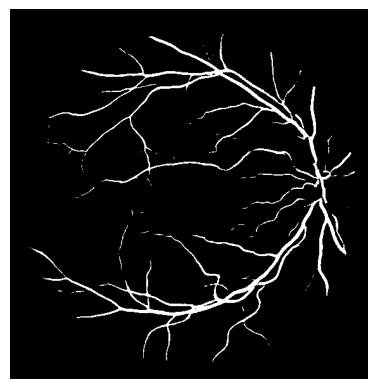

In [13]:
'''This is using regular FNR for risk control'''
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

'''Calculate false_negative_rate'''
import numpy as np
from scipy.optimize import brentq

# Assume cal_scores and cal_gt_masks are already defined
# cal_scores is the score matrix for the calibration set, and cal_gt_masks is the ground truth mask for the calibration set
# The shapes of cal_scores and cal_gt_masks should be (H, W, N), where N is the number of samples

n = cal_scores.shape[2]  # Number of samples
alpha = 0.5  # error-rate

# Define the False Negative Rate (FNR) function
def false_negative_rate(pred_masks, true_masks):
    """
    Calculate the False Negative Rate (FNR)

    Parameters:
    - pred_masks: binary predicted masks, shape (H, W, N)
    - true_masks: ground truth masks, shape (H, W, N)

    Returns:
    - float: the average False Negative Rate
    """
    # Ensure pred_masks and true_masks have the same shape
    assert pred_masks.shape == true_masks.shape, "Shapes of predicted and true masks are not consistent!"
    
    # Calculate FNR
    intersection = (pred_masks * true_masks).sum(axis=(0, 1))  # Compute intersection for each sample
    true_sum = true_masks.sum(axis=(0, 1))  # Total count for true mask in each sample
    fnr = 1 - (intersection / true_sum)  # FNR for each sample
    return fnr.mean()  # Return the mean FNR for all samples

# Define lamhat threshold function
def lamhat_threshold(lam):
    """
    Compute the difference between FNR and target at threshold lam, used to find the optimal lamhat

    Parameters:
    - lam: current threshold value

    Returns:
    - float: the difference between FNR and target value
    """
    pred_masks = cal_scores >= lam  # Generate predicted mask using current threshold
    return false_negative_rate(pred_masks, cal_gt_masks) - ((n + 1) / n * alpha - 1 / n)

# Find the optimal lamhat threshold using the brentq method
lamhat = brentq(lamhat_threshold, 0, 1)
print(f"Calculated lamhat threshold: {lamhat}")

# Assuming val_scores and val_idx are defined
# val_scores is the score matrix for validation, val_idx is the list of sample indices in the validation set
# output_folder is the path to save images
output_folder = "calculate_output"

predicted_masks = []
gt_masks = []

# Example loop to go through the first 5 samples
for i in range(5):
    rand_idx = val_idx[i] - 1  # Indices start from 0, so subtract 1
    
    # Get the predicted mask for a specific sample using threshold lamhat
    predicted_mask = val_scores[:, :, i] > lamhat  # Apply lamhat threshold to generate a binary mask
    predicted_masks.append(predicted_mask)
    gt_masks.append(val_gt_masks[:, :, i])
    
    # Plot and save the predicted mask
    fig, ax = plt.subplots(1, 1)
    ax.imshow(predicted_mask, cmap='gray')
    ax.axis('off')
    
# Metrics dictionary to store accuracy, dice, cldice, and 0-betti score
metrics = {'accuracy': [], 'dice': [], 'cldice': [], '0betti': []}
for i, pred in enumerate(predicted_masks):
    gt = gt_masks[i]
    cldice_acc = clDice(pred, gt)
    betti_acc = get_betti_error(pred, gt)
    dice_acc = dice_score(pred, gt)
    acc = accuracy_score(pred, gt)
    # Append metric scores for each sample
    metrics['accuracy'].append(acc)
    metrics['dice'].append(dice_acc)
    metrics['cldice'].append(cldice_acc)
    metrics['0betti'].append(betti_acc)
    print(f'Acc: {acc}; Dice: {dice_acc}; clDice: {cldice_acc}; 0-dim Betti: {betti_acc}')
# Calculate and print average metric values
for key, val in metrics.items():
    avg = np.array(val).mean()
    print(f"{key}: {avg}")

# Convert lists to numpy arrays for compatibility
predicted_masks = np.array(predicted_masks)
predicted_masks = np.transpose(predicted_masks, (1, 2, 0))
val_gt_masks = np.array(val_gt_masks)
print(val_gt_masks.shape)

# Calculate and print the empirical FNR
print(f"The empirical FNR is: {false_negative_rate(predicted_masks, val_gt_masks)} and the threshold value is: {lamhat}")

In [14]:
'''Score Transformation Strategy 1: Prioritize Topological Transformation'''
from PIL import Image
from matplotlib.colors import ListedColormap
import cc3d
from matplotlib import colors
import random
from scipy.spatial import distance

'''Selection Strategy'''
def select_area_topoPrior(x1, x2, s, delta_lamda, lamda_n1):
    # Find the new areas in x2 that are not present in x1
    x_delta = np.copy(x2)
    x_delta[x1 == 1] = 0  # Set parts of x1 to 0 in x_delta, leaving only new areas

    # Find the neighborhood of x_delta in x1
    x_delta_1 = np.copy(x_delta)
    for i in range(1, x_delta_1.shape[0] - 1):  # Traverse rows (avoid boundary points)
        for j in range(1, x_delta_1.shape[1] - 1):  # Traverse columns (avoid boundary points)
            if x_delta_1[i, j] == 1:
                flag = False
                neighbors = [(i + dx, j + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1] if (dx, dy) != (0, 0)]
                for ni, nj in neighbors:
                    if x1[ni, nj] == 1:  # If the neighbor is in x1
                        flag = True
                        break
                # If no neighbor is in x1, set x_delta_1 at that point to 0
                if not flag:
                    x_delta_1[i, j] = 0

    # Expand x_delta_1 =============
    # Use cc3d to get connected components of x_delta
    labels_out, numcomp = cc3d.connected_components(np.expand_dims(x_delta, axis=0), connectivity=26, return_N=True)
    labeled_delta = labels_out[0]  # Convert to 2D

    # Initialize x_delta_2 as the final result
    x_delta_2 = np.zeros_like(x_delta_1)

    # Traverse each element in x_delta_1, checking its component in x_delta
    for i in range(x_delta_1.shape[0]):
        for j in range(x_delta_1.shape[1]):
            if x_delta_1[i, j] == 1:
                component_label = labeled_delta[i, j]  # Get the component label of the point
                # If the label is valid, mark the component in x_delta_2
                if component_label > 0:
                    x_delta_2[labeled_delta == component_label] = 1

    # Mark completed expanded areas in x2_topo
    x2_topo = np.copy(x1)
    x2_topo[x_delta_2 == 1] = 1

    # Get x_delta_3 for score transformation
    x_delta_3 = np.copy(x_delta)
    x_delta_3[x_delta == x_delta_2] = 0

    # Score transformation
    if(True):
        # Expand 2D image to 3D for cc3d.connected_components to find 3D connectivity
        image_3d = np.expand_dims(x_delta_3, axis=0)
        labels_out, numcomp = cc3d.connected_components(image_3d, connectivity=26, return_N=True)
        x_delta_3_components_array = labels_out[0]  # Convert to 2D

        # Score transformation on x_delta_3 with the assumption that areas in x2_topo are not selectable
        x2_topo # Masked area x2_topo == x2 + Xtopo
        s # Score values to be transformed
        x_delta_3_components_array # Expand first, then search within the bounding box, excluding the masked area to find the highest value, replacing overall score for the component, otherwise decrease by delta_lamda
        mins = [] # To store all minimums
        for i in range(numcomp):
            # Retrieve coordinates of current component
            comps_coordinates = np.argwhere(x_delta_3_components_array == (i + 1))
            
            # Direct reduction works best!
            for m, n in comps_coordinates:
                    s[m, n] -= delta_lamda
    if(True):
        # Expand 2D image to 3D for cc3d.connected_components to find 3D connectivity
        image_3d = np.expand_dims(x_delta_3, axis=0)
        labels_out, numcomp = cc3d.connected_components(image_3d, connectivity=26, return_N=True)
        x_delta_3_components_array = labels_out[0]  # Convert to 2D
        for i in range(numcomp):
            
            component_mask = (x_delta_3_components_array == (i+1))  # Mask of current component
            comps_coordinates = np.argwhere(x_delta_3_components_array == (i + 1))
            pixel_count = len(comps_coordinates)
            print(f"Component {i+1} has {pixel_count} pixels")   
            if(pixel_count <= 1):
                continue
            
            def find_endpoints(segment):
                """
                Find the two endpoints of a given skeleton segment.
                Endpoint is defined as a point with only one neighbor.
                """
                segment = np.array(segment)
                segment_set = set(map(tuple, segment))
                endpoints = []

                if(len(segment)==1):
                    return segment[0], segment[0] 
                
                # Create an 8-connected adjacency list
                for point in segment:
                    x, y = point
                    neighbors = [
                        (x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1),
                        (x - 1, y - 1), (x - 1, y + 1), (x + 1, y - 1), (x + 1, y + 1)
                    ]

                    neighbor_count = sum([1 for n in neighbors if n in segment_set])
                    if neighbor_count == 1:
                        endpoints.append((x, y))

                if len(endpoints) >= 2:
                    endpoint1, endpoint2 = endpoints[:2]
                    return endpoint1, endpoint2
                if len(endpoints) == 1:
                    endpoint1 = endpoints[0]
                    endpoint2 = endpoints[0]
                    return endpoint1, endpoint2
                if len(endpoints) == 0:
                    return segment[0], segment[0] 

            endpoints = find_endpoints(comps_coordinates)
            
            if endpoints is None:
                raise ValueError("No valid endpoints found for the segment.")
            elif np.array_equal(endpoints[0], endpoints[1]):
                print(f"Warning: Duplicate endpoints found for the segment. Skipping this segment.")
                continue
            
            endpoint1, endpoint2 = endpoints
            dx = endpoint2[1] - endpoint1[1]
            dy = endpoint2[0] - endpoint1[0]
            direction_k = np.arctan2(dy, dx)  # Angle range -π to π

            length = distance.euclidean(endpoint1, endpoint2)
            pixel_count = len(comps_coordinates)

            result = {
                'endpoints': (tuple(endpoint1), tuple(endpoint2)),
                'direction_k': direction_k,
                'length': length,
                'pixel_count': pixel_count,
                'all_coordinates': comps_coordinates
            }
            length1 = length * 2
            length2 = length

            dx = endpoint2[1] - endpoint1[1]
            dy = endpoint2[0] - endpoint1[0]

            if np.isclose(direction_k, 0):
                if abs(dx) > abs(dy):
                    direction_k = np.array([0, 1])
                else:
                    direction_k = np.array([1, 0])
            else:
                direction_k = np.array([np.sin(direction_k), np.cos(direction_k)])

            def compute_moved_coordinates(length):
                positive_coords = np.round(comps_coordinates + direction_k * length).astype(int)
                negative_coords = np.round(comps_coordinates - direction_k * length).astype(int)
                return positive_coords, negative_coords

            pos_coords_1, neg_coords_1 = compute_moved_coordinates(length1)
            pos_coords_2, neg_coords_2 = compute_moved_coordinates(length2)

            move_comps_coordinates_positive = np.unique(
                np.vstack((pos_coords_1, pos_coords_2)), axis=0
            )
            move_comps_coordinates_negtive = np.unique(
                np.vstack((neg_coords_1, neg_coords_2)), axis=0
            )
            move_comps_coordinates_positive = move_comps_coordinates_positive[
                (move_comps_coordinates_positive[:, 0] >= 0) & (move_comps_coordinates_positive[:, 0] < s.shape[0]) &
                (move_comps_coordinates_positive[:, 1] >= 0) & (move_comps_coordinates_positive[:, 1] < s.shape[1])
            ]
            move_comps_coordinates_negtive = move_comps_coordinates_negtive[
                (move_comps_coordinates_negtive[:, 0] >= 0) & (move_comps_coordinates_negtive[:, 0] < s.shape[0]) &
                (move_comps_coordinates_negtive[:, 1] >= 0) & (move_comps_coordinates_negtive[:, 1] < s.shape[1])
            ]
            nums_intersection_positive = 0
            nums_intersection_negtive = 0

            x2_topo_coords = set(map(tuple, np.argwhere(x2_topo)))
            current_component_coords = set(map(tuple, comps_coordinates))

            x_delta_3_all_coords = set(map(tuple, np.argwhere(x_delta_3)))
            x_delta_3_other_coords = x_delta_3_all_coords - current_component_coords

            for coord in map(tuple, move_comps_coordinates_positive):
                if coord in x_delta_3_other_coords or coord in x2_topo_coords:
                    nums_intersection_positive += 1

            for coord in map(tuple, move_comps_coordinates_negtive):
                if coord in x_delta_3_other_coords or coord in x2_topo_coords:
                    nums_intersection_negtive += 1

            if nums_intersection_positive > nums_intersection_negtive:
                move_comps_coordinates = move_comps_coordinates_positive
                intersection_point = next((coord for coord in move_comps_coordinates if tuple(coord) in x2_topo_coords), None)
                print("Positive direction, enhance s value")
            elif nums_intersection_positive < nums_intersection_negtive:
                move_comps_coordinates = move_comps_coordinates_negtive
                intersection_point = next((coord for coord in move_comps_coordinates if tuple(coord) in x2_topo_coords), None)
                print("Negative direction, enhance s value")
            elif nums_intersection_positive == 0 and nums_intersection_negtive == 0:
                print("Neither direction intersects, no operation")
                continue
            else:
                print("Neither direction, no operation")
                continue
            
            start_point = comps_coordinates[0]
            final_increase_nums = 0

            if intersection_point is not None:
                direction_vector = np.array(intersection_point) - np.array(start_point)
                
                for coord in move_comps_coordinates:
                    current_vector = np.array(coord) - np.array(start_point)
                    if np.dot(current_vector, direction_vector) >= 0 and np.linalg.norm(current_vector) <= np.linalg.norm(direction_vector):
                        if (0 <= coord[0] < s.shape[0] and 0 <= coord[1] < s.shape[1]) and not x2_topo[coord[0], coord[1]]:
                            s[coord[0], coord[1]] += delta_lamda * 20
                            final_increase_nums += 1
                            if s[coord[0], coord[1]] > (lamda_n1 - delta_lamda):
                                s[coord[0], coord[1]] = lamda_n1 - delta_lamda
                print(f"final_increase_nums={final_increase_nums}")
            else:
                print("No intersection found, no enhancement operation.")

    return x2_topo, s

''' First round of high-threshold segmentation to remove small connected components '''
def first_mask_topo_process(mask, remove_min_size):
    labels_out, numcomp = cc3d.connected_components(mask, connectivity=8, return_N=True)
    unique_labels, counts = np.unique(labels_out, return_counts=True)
    remove_labels = unique_labels[counts < remove_min_size]
    mask[np.isin(labels_out, remove_labels)] = 0
    return mask

''' Iteratively perform score transformation '''
def score_transform_topo(no, predicted_mask_n, lamda_n, delta_lamda, n_iteration):
    if(lamda_n <= 0):
        return
    lamda_n = lamda_n
    delta_lamda = delta_lamda
    s = np.copy(val_scores[:, :, no])
    final_result_s = None
    for i in range(n_iteration):
        lamda_n1 = lamda_n - delta_lamda
        predicted_mask_n1 = s > lamda_n1
        topo_predicted_mask_n1, s_topo = select_area_topoPrior(predicted_mask_n, predicted_mask_n1, s, delta_lamda, lamda_n1)
        lamda_n = lamda_n1
        predicted_mask_n = topo_predicted_mask_n1        
        s = s_topo
        final_result_s = s_topo
    return final_result_s


''' main '''
no = 2 # Test image 2, total of 5 images
lamda_n = 0.9

predicted_mask_n = val_scores[:, :, no] > lamda_n
predicted_mask_n = first_mask_topo_process(predicted_mask_n, remove_min_size=10)
s = score_transform_topo(no, predicted_mask_n, lamda_n, delta_lamda=0.01, n_iteration=89)

Component 1 has 1 pixels
Component 2 has 2 pixels
Neither direction intersects, no operation
Component 3 has 1 pixels
Component 4 has 1 pixels
Component 5 has 1 pixels
Component 6 has 2 pixels
Neither direction intersects, no operation
Component 7 has 2 pixels
Neither direction intersects, no operation
Component 8 has 9 pixels
Positive direction, enhance s value
final_increase_nums=9
Component 9 has 1 pixels
Component 10 has 5 pixels
Negative direction, enhance s value
final_increase_nums=3
Component 11 has 6 pixels
Negative direction, enhance s value
No intersection found, no enhancement operation.
Component 12 has 5 pixels
Component 13 has 9 pixels
Component 14 has 2 pixels
Neither direction intersects, no operation
Component 15 has 4 pixels
Positive direction, enhance s value
final_increase_nums=2
Component 16 has 2 pixels
Neither direction intersects, no operation
Component 17 has 10 pixels
Negative direction, enhance s value
final_increase_nums=13
Component 18 has 5 pixels
Positiv

In [17]:
gt_mask = val_gt_masks[:, :, no]
for lamda_i in [0.005,0.01,0.02,0.03,0.14,0.3,0.5,0.6,0.8]:
  print(f"====== lamda_i: {lamda_i} ========")
  metrics = {'accuracy':[], 'dice':[], 'cldice':[], '0betti':[]}

  predicted_mask = val_scores[:, :, no] > lamda_i
  pred = predicted_mask
  cldice_acc = clDice(pred, gt_mask)
  betti_acc = get_betti_error(pred, gt_mask)
  dice_acc = dice_score(pred, gt_mask)
  acc = accuracy_score(pred, gt_mask)
  metrics['accuracy'].append(acc)
  metrics['dice'].append(dice_acc)
  metrics['cldice'].append(cldice_acc)
  metrics['0betti'].append(betti_acc)
  print(f'[normal] Acc: {acc}; Dice: {dice_acc}; clDice: {cldice_acc}; 0-dim Betti: {betti_acc} The empirical FNR is: {false_negative_rate(pred, gt_mask)}')

  topo_predicted_mask_n = s > lamda_i
  pred = topo_predicted_mask_n
  cldice_acc = clDice(pred, gt_mask)
  betti_acc = get_betti_error(pred, gt_mask)
  dice_acc = dice_score(pred, gt_mask)
  acc = accuracy_score(pred, gt_mask)
  metrics['accuracy'].append(acc)
  metrics['dice'].append(dice_acc)
  metrics['cldice'].append(cldice_acc)
  metrics['0betti'].append(betti_acc)
  print(f'[Toto] ==== Acc: {acc}; Dice: {dice_acc}; clDice: {cldice_acc}; 0-dim Betti: {betti_acc} The empirical FNR is: {false_negative_rate(pred, gt_mask)}')


====== lamda_i: 0.005 ========
[normal] Acc: 0.7717753667111165; Dice: 0.4084957309266285; clDice: 0.4593742065282266; 0-dim Betti: 11.38888888888889 The empirical FNR is: 0.00539320707321167
[Toto] ==== Acc: 0.7788883501030428; Dice: 0.4157002819067145; clDice: 0.4160817792007365; 0-dim Betti: 11.972222222222221 The empirical FNR is: 0.0073056817054748535
====== lamda_i: 0.01 ========
[normal] Acc: 0.8795672202691235; Dice: 0.5649251116755715; clDice: 0.6800786585594625; 0-dim Betti: 5.833333333333333 The empirical FNR is: 0.013196170330047607
[Toto] ==== Acc: 0.889335070917687; Dice: 0.5847689875936729; clDice: 0.7263068243797255; 0-dim Betti: 0.7777777777777778 The empirical FNR is: 0.01652383804321289
====== lamda_i: 0.02 ========
[normal] Acc: 0.9149290823130076; Dice: 0.6454733757704355; clDice: 0.7856573758861197; 0-dim Betti: 3.1527777777777777 The empirical FNR is: 0.022605597972869873
[Toto] ==== Acc: 0.9186386228633774; Dice: 0.6550864660688132; clDice: 0.8041687855701588; 0